In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk import tokenize 
from string import punctuation
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurpedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arthurpedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/arthurpedro/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [3]:
stop_words 


{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estar',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houverí

In [4]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text_without_tags = soup.get_text()
    return text_without_tags

In [5]:
def remove_parenteses_from_begin_text(frase):
    rx = r'^\([^)]+\)'
    text_without_parenteses = re.sub(rx, '', frase)
    return text_without_parenteses

In [6]:
def remove_punctuation(sentence):
    translator = str.maketrans('', '', punctuation)
    return sentence.translate(translator)

In [7]:
def remove_unnecessary_words(text):
    words = nltk.word_tokenize(text)
    text_without_stop_words = [word for word in words if word.lower() not in stop_words]
    text_without_stop_words = " ".join(text_without_stop_words)
    # texto_sem_especiais = re.sub(r'[^a-zA-Z0-9\s]', '', " ".join(text_without_stop_words))
    text_without_extra_white_spaces = re.sub(r'\s+', ' ', text_without_stop_words)
    text_without_punctuation = remove_punctuation(text_without_extra_white_spaces)
    return text_without_punctuation

In [8]:
def convert_to_lowercase(text):
    return text.lower()

In [9]:
def remove_specific_words(text):
    tokenized_words = nltk.word_tokenize(text)
    words_to_remove = ["incorreta", "correta", "errada", "certa", "errado", "certo", "alternativa", "a", "b", "c", "d", "e"]
    text_without_specifics_words = [word for word in tokenized_words if word.lower() not in words_to_remove]
    
    # Usa stemmer, para remover palavras com mesmo radical
    # text_without_specifics_words = [stemmer.stem(word) for word in tokenized_words if word.lower() not in words_to_remove]
    text_without_specifics_words = " ".join(text_without_specifics_words)
    return text_without_specifics_words
remove_specific_words("A alternativa alternativas correta é a A")

'alternativas é'

In [10]:
dataset = pd.read_csv("./emr_dataset.csv")
dataset.head(20)

,specialty,title,extra_info
0,CIRURGIA,"<b>(SES-PE 2014 R3 CIRURGIA)</b><p>""Sobre a Hi...",A) Incorreta. As causas mais comuns de hiperte...
1,CIRURGIA,<b>(SUS-SP 2022 R3 CIRURGIA)</b><p>Um homem de...,A questão trás um paciente com sangramento ao ...
2,CIRURGIA,"<b>(USP-RP 2017 ACESSO DIRETO)</b><p>Homem, 57...",Estamos diante de um paciente apresentando san...
3,NEFROLOGIA,<b>(SUS-SP 2017 ACESSO DIRETO)</b><p>Para calc...,O ânion gap é calculado por: Sódio - (cloreto ...
4,PREVENTIVA,<b>(ABC-SP 2017 ACESSO DIRETO)</b><p>Sobre os ...,Ops! Nossa equipe está produzindo esse comentá...
5,NEUROLOGIA,<b>(PSU-MG 2018 ACESSO DIRETO)</b><p>No que co...,"A hemorragia subaracnóidea espontânea (HSAe), ..."
6,HEMATOLOGIA,"<b>(UNICAMP 2021 ACESSO DIRETO)</b>Homem, 24a,...",A questão discorre sobre complicações hepatob...
7,PEDIATRIA,"<b>(SES-PE 2009 R3 PEDIATRIA)</b><p>""Na avalia...",A - CORRETA: O contato social deve ser percebi...
8,CIRURGIA,<b>(UFRJ 2022 ACESSO DIRETO)</b><p>O método ma...,O método mais adequado de fechamento da parede...
9,GINECOLOGIA E OBSTETRÍCIA,<b>(IAMSPE-SP 2016 ACESSO DIRETO)</b><p>O padr...,Questão sobre amniorrexe prematura. É preciso ...


In [11]:
dataset = dataset.dropna(subset=['title', 'extra_info'])

In [12]:
dataset["title"] = dataset["title"].apply(remove_html_tags)
dataset["title"] = dataset["title"].apply(remove_parenteses_from_begin_text)

In [13]:
dataset["title"] = dataset["title"].apply(convert_to_lowercase)
dataset["extra_info"] = dataset["extra_info"].apply(convert_to_lowercase)

In [14]:
# dataset["title"] = dataset["title"].apply(remove_specific_words)
# dataset["extra_info"] = dataset["extra_info"].apply(remove_specific_words)

In [15]:
dataset["title"].head()

0    "sobre a hipertensão porta (hp) e sua fisiopat...
1    um homem de sessenta anos de idade, sem comorb...
2    homem, 57 anos, vítima de colisão moto x carro...
3    para calcular o anion gap de um paciente são n...
4    sobre os desenhos de estudos epidemiológicos, ...
Name: title, dtype: object

In [16]:
dataset["title"] = dataset["title"].apply(remove_unnecessary_words)
dataset["extra_info"] = dataset["extra_info"].apply(remove_unnecessary_words)

In [17]:
# dataset["title"] = dataset["title"].apply(stemmer)
# dataset["extra_info"] = dataset["extra_info"].apply(stemmer)

In [18]:
dataset.head(20)

,specialty,title,extra_info
0,CIRURGIA,sobre hipertensão porta hp fisiopatologia ...,incorreta causas comuns hipertensão portal p...
1,CIRURGIA,homem sessenta anos idade comorbidades chego...,questão trás paciente sangramento evacuar toqu...
2,CIRURGIA,homem 57 anos vítima colisão moto x carro ro...,diante paciente apresentando sangue cavidade a...
3,NEFROLOGIA,calcular anion gap paciente necessários seguin...,ânion gap calculado sódio cloreto bicarbon...
4,PREVENTIVA,sobre desenhos estudos epidemiológicos marque...,ops equipe produzindo comentário escrito brev...
5,NEUROLOGIA,concerne hemorragia subaracnoidea espontânea ...,hemorragia subaracnóidea espontânea hsae ge...
6,HEMATOLOGIA,homem 24a procura unidade emergência dor int...,questão discorre sobre complicações hepatobili...
7,PEDIATRIA,avaliação desenvolvimento criança ausência a...,correta contato social deve percebido ainda ...
8,CIRURGIA,método adequado fechamento parede abdominal ca...,método adequado fechamento parede abdominal ca...
9,GINECOLOGIA E OBSTETRÍCIA,padrãoouro diagnóstico amniorrexe prematura,questão sobre amniorrexe prematura preciso at...


In [19]:
questions = dataset["title"]

extra_info = dataset['extra_info']

categories = dataset["specialty"]

context = questions + extra_info

In [20]:
# Get word cloud by specialty
# cirurgy_dataset = dataset.query("specialty == 'GINECOLOGIA E OBSTETRÍCIA'")
# cirurgy_questions = cirurgy_dataset["title"] + cirurgy_dataset["extra_info"]

In [21]:
all_words = ' '.join([text for text in context])

In [22]:
word_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, collocations=False).generate(all_words)

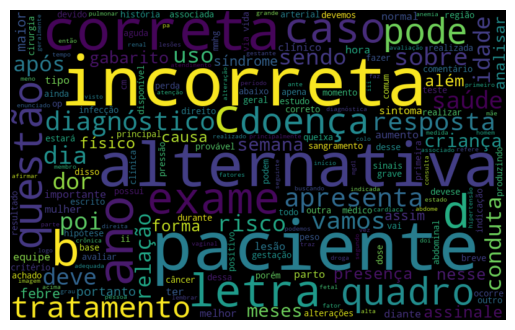

In [23]:
plt.figure()
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:

word_frequence = nltk.FreqDist(nltk.word_tokenize(all_words))
df_frequence = pd.DataFrame({ 'word': list(word_frequence.keys()), "frequence": list(word_frequence.values()) })
df_frequence = df_frequence.nlargest(columns="frequence", n=10)
df_frequence.head(10)


,word,frequence
8,incorreta,58629
63,paciente,51106
7,correta,40541
121,–,37866
6,alternativa,33888
85,anos,29574
21,b,29056
35,c,28601
49,d,27031
82,letra,24931


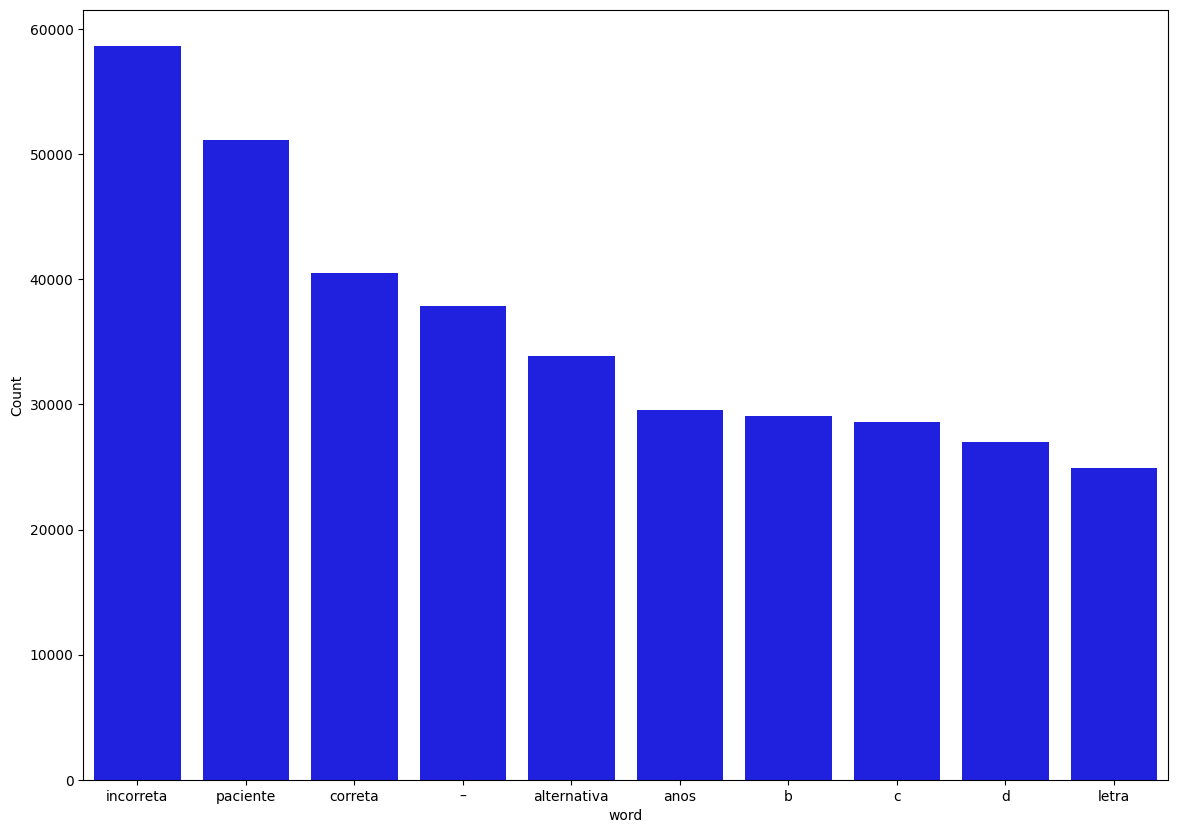

In [25]:
plt.figure(figsize=(14, 10))
ax = sns.barplot(data = df_frequence, x = 'word', y = 'frequence', color='blue')
ax.set(ylabel = 'Count')
plt.show()

In [40]:
# TF - IDF -> Termo de frequencia. Inverso de frequencia do documento. Significa que quanto mais frequente uma palavra 
# é em um documento, mais importante ela é para o documento. 
# Aplica peso as palavras mais importantes

# Vetorize as perguntas
# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2), max_features=90000)
X = vectorizer.fit_transform(questions + extra_info)

In [27]:
pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out()).head(10)

,00,000,0001,000mm3,001,002,003,005,006,007,...,útil casos,útil definir,útil diagnóstico,útil diferenciar,útil nesse,útil seguinte,úvula,úvula palato,βhcg,βhcg negativo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, categories, test_size=0.2, random_state=42)


In [42]:
param_grid = {'alpha': [0.1, 1.0, 10.0], 'fit_prior': [True, False]}

In [43]:
# Inicialize e treine o classificador Naive Bayes
multinomial_classifier = MultinomialNB()
multinomial_classifier.fit(X_train, y_train)

# Avalie a precisão do modelo nos dados de teste
# multinomial_accuracy = multinomial_classifier.score(X_test, y_test)

grid_search = GridSearchCV(multinomial_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

multinomial_accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia do modelo multinomial: {multinomial_accuracy * 100}%")


/Users/arthurpedro/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Acurácia do modelo multinomial: 84.3290502053252%


In [44]:
feature_names = vectorizer.get_feature_names_out()
log_probs = pd.DataFrame(best_model.feature_log_prob_, columns=feature_names)

In [49]:
logistic_regretion_classifier = LogisticRegression()
logistic_regretion_classifier.fit(X_train, y_train)

# param_grid = {
#     'penalty': ['l1', 'l2'],           # Regularização (l1 - Lasso, l2 - Ridge)
#     'C': [0.1, 1.0, 10.0],             # Inverso da força de regularização
#     'solver': ['liblinear', 'lbfgs'],  # Algoritmo de otimização (liblinear para l1, lbfgs para l2)
#     'max_iter': [100, 200, 500]        # Número máximo de iterações
# }

# grid_search = GridSearchCV(logistic_regretion_classifier, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_model = grid_search.best_estimator_
y_pred = logistic_regretion_classifier.predict(X_test)

logistic_regretion_accuracy = accuracy_score(y_test, y_pred)

# logistic_regretion_accuracy = logistic_regretion_classifier.score(X_test, y_test)
print(f"Acurácia do modelo logistic regretion: {logistic_regretion_accuracy * 100}%")

Acurácia do modelo logistic regretion: 83.6932043979335%


In [46]:
# Exemplo de perguntas para categorizar
novas_perguntas = [
    "Quais são os melhores remédios para dor de cabeça?",
    "Como identificar os sinais de um ataque cardíaco?",
    "Como cuidar da alimentação durante a gestação?",
    # ... adicione mais perguntas para categorizar
]

In [47]:
# Vetorize as novas perguntas
X_novas_perguntas = vectorizer.transform(novas_perguntas)

# Categorize as novas perguntas
categorias_preditas = best_model.predict(X_novas_perguntas)

In [48]:
# Imprima as categorias preditas para as novas perguntas
for pergunta, categoria in zip(novas_perguntas, categorias_preditas):
    print(f"Pergunta: {pergunta}\nCategoria: {categoria}\n")

Pergunta: Quais são os melhores remédios para dor de cabeça?
Categoria: NEUROLOGIA

Pergunta: Como identificar os sinais de um ataque cardíaco?
Categoria: CARDIOLOGIA

Pergunta: Como cuidar da alimentação durante a gestação?
Categoria: PEDIATRIA

